In [1]:
import sagemaker
from sagemaker.local import LocalSession
import uuid

In [2]:
sagemaker_session = sagemaker.Session()
print('sagemaker version:' + sagemaker.__version__)

sagemaker version:2.74.0


In [3]:
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/eva7-cifar100-v1'
role = sagemaker.get_execution_role()

In [4]:
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket, checkpoint_suffix)

In [5]:
print('Checkpointing Path: {}'.format(checkpoint_s3_path))
print(f'Role is {role}')
print(f'Bucket is {bucket}')

Checkpointing Path: s3://sagemaker-us-east-2-363027134642/checkpoint-c46657f2
Role is arn:aws:iam::363027134642:role/service-role/AmazonSageMaker-ExecutionRole-20220227T214601
Bucket is sagemaker-us-east-2-363027134642


In [6]:
import os, sys
import subprocess 

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    # Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print('instance_type:', instance_type)

instance_type: local


In [7]:
pip install pytorch_lightning --quiet

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pytorch_lightning as pl
print(pl.__version__)

1.5.10


In [9]:
# Generic Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os, re
from skimage import io

# Pytorch related Imports
import torchvision, torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torch.optim.lr_scheduler import OneCycleLR

# lightning related imports
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from pytorch_lightning import seed_everything  # Global Seeding
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import ModelSummary

In [10]:
inputs = sagemaker_session.upload_data(
    path="data", bucket=bucket, key_prefix=prefix
)

In [11]:
print(inputs)
print(bucket)

s3://sagemaker-us-east-2-363027134642/sagemaker/eva7-cifar100-v1
sagemaker-us-east-2-363027134642


In [12]:
from sagemaker.pytorch import PyTorch

In [13]:
use_spot_instances = True
max_run = 600
max_wait = 1200 if use_spot_instances else None

In [14]:
checkpoint_local_path = "/opt/ml/checkpoints"

In [15]:
hyperparameters = {"batch_size": 128}

In [16]:
cifar100_estimator = PyTorch(
    entry_point="cifar100_pl.py",
    role=role,
    framework_version="1.7.1",
    py_version="py3",
    source_dir='./source_dir',
    hyperparameters=hyperparameters,
    instance_count=2,
    instance_type="ml.c5.9xlarge", # "ml.p3.8xlarge",
    base_job_name="cifar100-Feb28-spot",
    checkpoints_s3_uri=checkpoint_s3_path,
    checkpoint_local_path=checkpoint_local_path,
    debugger_hook_config=False,
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait,
)

In [17]:
cifar100_estimator.fit(inputs)

2022-02-28 13:15:03 Starting - Starting the training job...
2022-02-28 13:15:05 Starting - Launching requested ML instancesProfilerReport-1646054092: InProgress
......
2022-02-28 13:16:30 Starting - Preparing the instances for training.........
2022-02-28 13:17:57 Downloading - Downloading input data...
2022-02-28 13:18:33 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-28 13:18:23,913 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-28 13:18:23,914 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-28 13:18:23,923 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-28 13:18:23,806 sagemaker-training-toolki

In [18]:
cifar100_estimator.model_data

's3://sagemaker-us-east-2-363027134642/cifar100-Feb28-spot-2022-02-28-13-14-52-582/output/model.tar.gz'

In [19]:
from sagemaker.pytorch import PyTorchModel

In [20]:
predictor = cifar100_estimator.deploy(initial_instance_count=1, instance_type="ml.c4.8xlarge")

------!

In [21]:
from source_dir.cifar100_pl import unpickle, imshow, CIFAR100DataModule

In [22]:
# The below part takes CIFAR100DataModule defined inside the cifar100_pl.py file, and defines
# the DataLoader for training, validation and test data

dm = CIFAR100DataModule(batch_size=128)
dm.prepare_data()
dm.setup()

Files already downloaded and verified
Files already downloaded and verified


In [23]:
# train and test loaders defined

trainloader = dm.train_dataloader()
testloader = dm.test_dataloader()

In [24]:
metaData = unpickle("./data/cifar-100-python/meta")

label_names = metaData["fine_label_names"]
print(len(label_names))

100


In [25]:
# get some test images
dataiter = iter(testloader)

In [26]:
images, labels = dataiter.next()
print(images.size())

labels_list = labels.tolist()

torch.Size([4, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth:  mountain forest seal mushroom


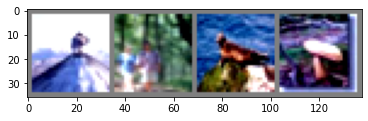

In [27]:
# print images
imshow(torchvision.utils.make_grid(images))
print("Ground Truth: ", " ".join("%4s" % label_names[labels_list[j]] for j in range(4)))

In [28]:
outputs = predictor.predict(images.numpy())
_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

In [29]:
print("Predicted: ", " ".join("%4s" % label_names[predicted[j]] for j in range(4)))

Predicted:  road kangaroo otter mushroom


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 32, 32])
Ground Truth:  streetcar rocket lamp lion
Predicted:  streetcar rocket lamp lion


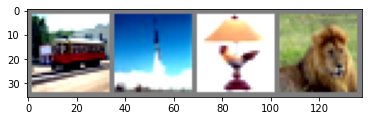

In [32]:
images, labels = dataiter.next()
print(images.size())

labels_list = labels.tolist()

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground Truth: ", " ".join("%4s" % label_names[labels_list[j]] for j in range(4)))

outputs = predictor.predict(images.numpy())
_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % label_names[predicted[j]] for j in range(4)))

In [34]:
predictor.delete_endpoint()